In [1]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.lf_vmax as vmax
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import astropy.table as table

/Users/runburg/github/agn_lf


In [2]:
hdu = fits.open('./data/SWIRE_and_XSERVS.fits')
print(hdu[0].header)
print(hdu[1].header)
x_ray_catalog = table.Table.read('./data/SWIRE_and_XSERVS.fits')

SIMPLE  =                    T / Standard FITS format                           BITPIX  =                    8 / Character data                                 NAXIS   =                    1 / Text string                                    NAXIS1  =                25562 / Number of characters                           VOTMETA =                    T / Table metadata in VOTable format               EXTEND  =                    T / There are standard extensions                  COMMENT                                                                         COMMENT The data in this primary HDU consists of bytes which                    COMMENT comprise a VOTABLE document.                                            COMMENT The VOTable describes the metadata of the table contained               COMMENT in the following BINTABLE extension.                                    COMMENT Such a BINTABLE extension can be used on its own as a perfectly         COMMENT good table, but the information 

In [3]:
# x_ray_catalog

In [4]:
band = 'LX'
sample_indices = (x_ray_catalog[band] > -99)
sample = x_ray_catalog[sample_indices]
print(len(sample))

499


In [5]:
cosmo = af.setup_cosmology()

In [6]:
redshifts = [row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in sample]
lums = sample[band]
print(len(redshifts))
print(len(lums))
# redshifts

499
499


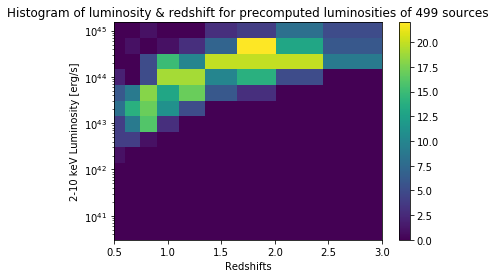

In [7]:
fig, ax = plt.subplots()
num_bins_red = 10
num_bins_l = 15
# redshift range 
red_bins = np.logspace(np.log10(0.5), np.log10(3), num=num_bins_red)
lum_bins = np.logspace(np.amin(loglums:=np.log10(lums)), np.amax(loglums), num=num_bins_l)
histo, _, _, im = ax.hist2d(redshifts, lums, bins=[red_bins, lum_bins])
ax.set_yscale('log')
ax.set_xlabel('Redshifts')
ax.set_ylabel('2-10 keV Luminosity [erg/s]')
fig.colorbar(im)
ax.set_title(rf'Histogram of luminosity & redshift for precomputed luminosities of {len(sample)} sources');

In [8]:
import source.vmax as vmax

In [9]:
redshifts = [row['ZSPEC'] if row['ZSPEC'] > 0 else row['ZPHOT'] for row in sample]
lums = sample[band]
sample['sample_flag'] = (redshifts > red_bins[0]) & (redshifts < red_bins[-1]) & (lums > lum_bins[0]) & (lums < lum_bins[-1])
# redshift_bins = np.linspace(0, 3.5, num=7)
# within_range_indices = (redshifts > red_bins[0]) & (redshifts < red_bins[-1])
# print(within_range_indices)
reds = np.array(redshifts)[sample['sample_flag']]
# print(lums.data)
luminosities = np.array(lums.data)[sample['sample_flag']]
z_insert_indices = np.searchsorted(red_bins, reds)
# print(z_insert_indices)
l_insert_indices = np.searchsorted(lum_bins, luminosities)
# vmax.compute_binned_vmax_values(luminosities, reds, lum_bins, red_bins, cosmo)

vmaxes = [vmax.calc_v_max(red_bins[i-1], red_bins[i], lum_bins[j-1], lum_bins[j], lambda l,z: 5.6, cosmo) for i, j in zip(z_insert_indices, l_insert_indices)] 

In [10]:
lf_values = []
for zbin in range(1, len(red_bins)):
    objs_in_zbin = (z_insert_indices == zbin)
    z = reds[objs_in_zbin]
    l = luminosities[objs_in_zbin]
    v = np.array(vmaxes)[objs_in_zbin]
    phi = vmax.compute_lf_vmax_per_z_bin(l, v, lum_bins)
    lf_values.append(phi)


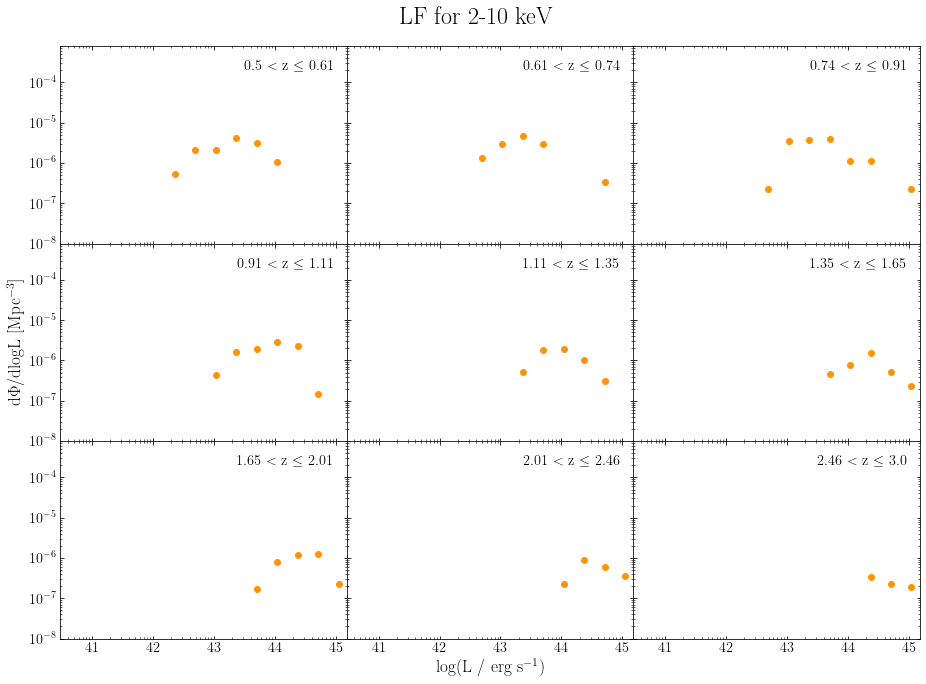

In [11]:
import source.vmax as vmax
import importlib
importlib.reload(vmax)
vmax.plot_lf_vmax(lf_values, red_bins, lum_bins, title='LF for 2-10 keV');

In [12]:
import source.vmax as vmax
import importlib
importlib.reload(vmax)
import source.astro_functions as af
cosmo = af.setup_cosmology()
z = reds
l = luminosities

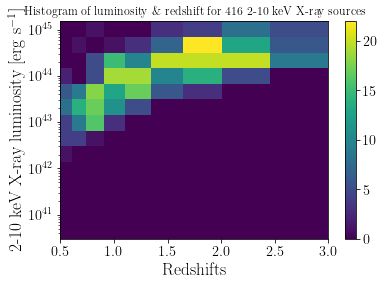

In [14]:
num_bins_z = 10
num_bins_l = 15
# redshift range 
z_bins = red_bins
l_bins = lum_bins
fig, ax = vmax.l_z_histo(l, z, l_bins, z_bins, band='2-10 keV X-ray', unit=r'erg s$^{-1}$')

In [15]:
vmax_vals = vmax.compute_binned_vmax_values(l, z, lum_bins, red_bins, cosmo)

In [16]:
lf_vals = vmax.compute_lf_values(l, z, vmax_vals, z_bins, l_bins)

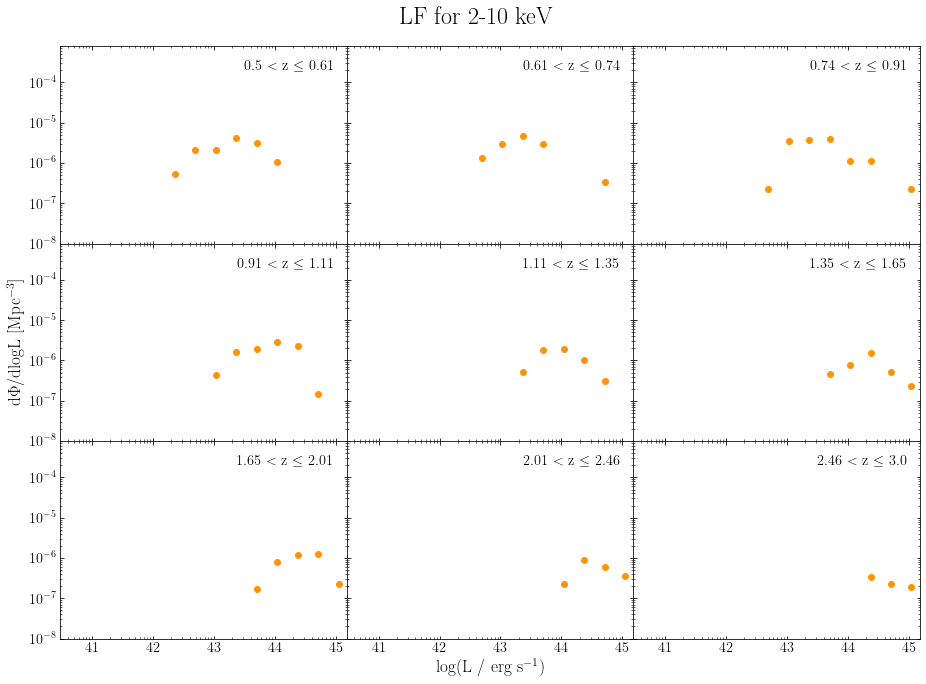

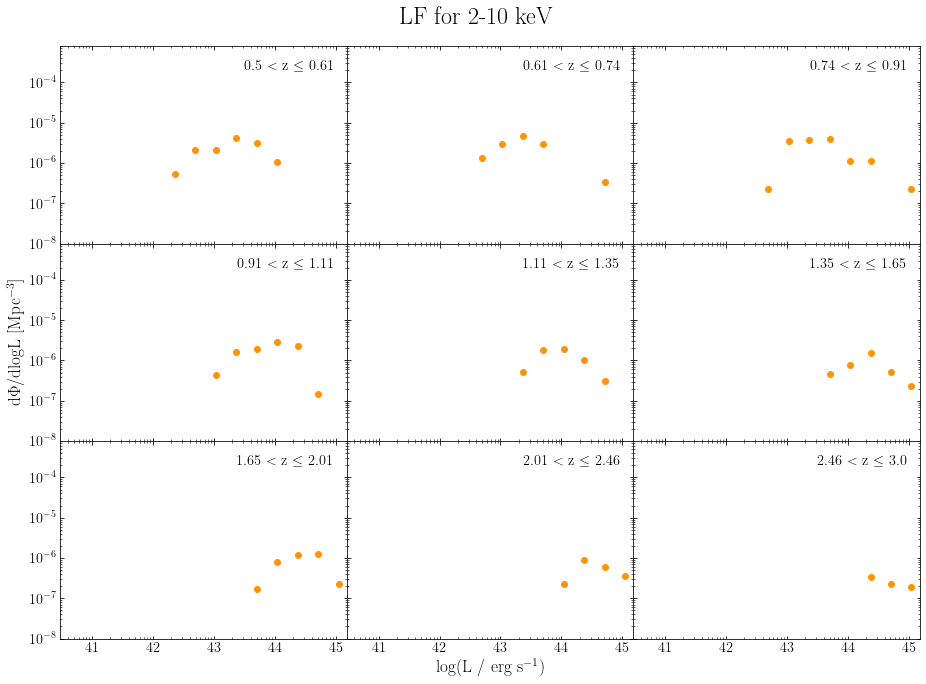

In [17]:
fig, axs, big_ax = vmax.plot_lf_vmax(lf_vals, z_bins, l_bins, title='LF for 2-10 keV', outfile='./xray_lf.png')
fig